In [79]:
import pandas as pd
import numpy as np
import quantiacsToolbox
from pmdarima import auto_arima
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.layers import Dropout
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Reading Data

In [ ]:
markets = ['F_AD','F_BO','F_BP','F_C','F_CC','F_CD','F_CL',
        'F_CT','F_DX','F_EC','F_ES','F_FC','F_FV','F_GC','F_F',
        'F_HG','F_HO','F_JY','F_KC','F_LB','F_LC','F_LN','F_MD',
        'F_MP','F_NG','F_NQ','F_NR','F_O','F_OJ','F_PA','F_PL',
        'F_RB','F_RU','F_S','F_SB','F_SF','F_SI','F_SM','F_TU',
        'F_TY','F_US','F_W','F_XX','F_YM','F_AX','F_CA','F_DT',
        'F_UB','F_UZ','F_GS','F_LX','F_DL','F_ZQ','F_VX','F_SS',
        'F_AE','F_BG','F_BC','F_LU','F_DM','F_AH','F_CF','F_DZ',
        'F_FB','F_FL','F_FM','F_FP','F_FY','F_GX','F_HP','F_LR',
        'F_LQ','F_ND','F_NY','F_PQ','F_RR','F_RF','F_RP','F_RY',
        'F_SH','F_SX','F_TR','F_EB','F_VF','F_VT','F_VW','F_GD']

In [3]:
curr_futures = 'F_AD'
filename = '~/Desktop/Team_Ravioli_Timeseries/tickerData/'+curr_futures+'.txt'

In [4]:
data = pd.read_csv(filename, sep = ",", header = None)
data.columns = [i.strip() for i in data.iloc[0]]
data = data[1:-1]
data = data.apply(pd.to_numeric)
data= data.reset_index()

In [5]:
data.head()

,index,DATE,OPEN,HIGH,LOW,CLOSE,VOL,OI,P,R,RINFO
0,1,19900102,77300.0,77400.0,77020.0,77020.0,125,2559,0,0,0.0
1,2,19900103,76890.0,77030.0,76700.0,76740.0,1495,3215,0,0,0.0
2,3,19900104,77080.0,77610.0,77000.0,77490.0,932,3122,0,0,0.0
3,4,19900105,77050.0,77280.0,76980.0,76980.0,272,2542,0,0,0.0
4,5,19900108,77280.0,77300.0,77090.0,77200.0,177,2430,0,0,0.0


# 2. Preprocess Data

## 2.1 Creating Technical Indicators

In [6]:
# Create 7 and 21 days Moving Average
data['ma7'] = data['CLOSE'].rolling(window=7).mean()
data['ma21'] = data['CLOSE'].rolling(window=21).mean()
    
# Create MACD
data['26ema'] = data['CLOSE'].ewm(span = 26).mean()
data['12ema'] = data['CLOSE'].ewm(span = 12).mean()
data['MACD'] = (data['12ema']-data['26ema'])

# Create Bollinger Bands
data['20sd'] = data['CLOSE'].rolling(window=20).std()
data['ma20'] = data['CLOSE'].rolling(window=20).mean()
data['upper_band'] = data['ma20'] + (data['20sd']*2)
data['lower_band'] = data['ma20'] - (data['20sd']*2)
    
# Create Exponential moving average
# exponential weighted function with decay term = 0.5, 𝛼=1/(1+𝑐𝑜𝑚)
data['ema'] = data['CLOSE'].ewm(com=0.5).mean()
    
# Create Momentum
data['momentum'] = data['CLOSE']-1

In [80]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['CLOSE'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')

    plt.legend()
    plt.show()

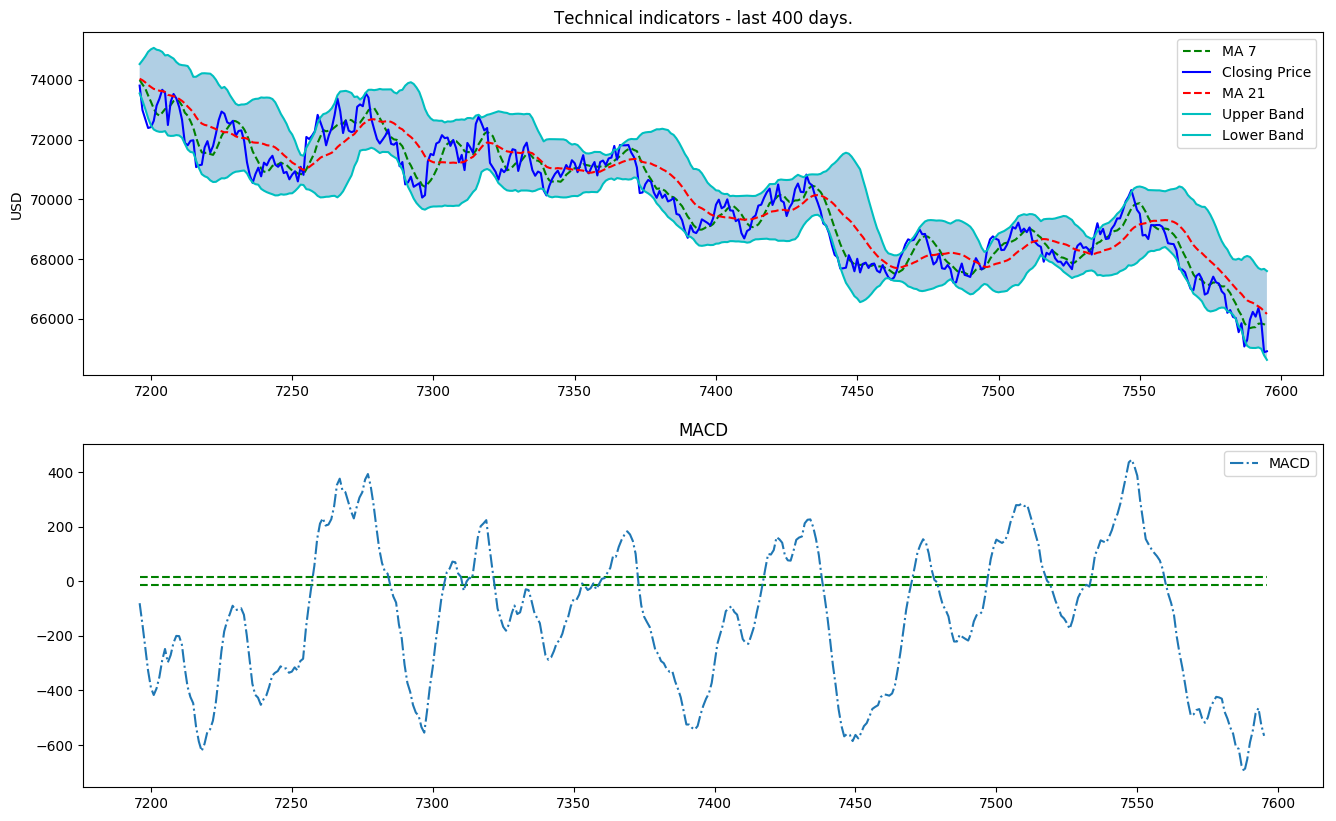

In [81]:
plot_technical_indicators(data, 400)

In [ ]:
# normalise the input
# normalisation mainly affects the speed of conversion 
# check the scale of the features and see whether normalisation is needed
def normalise(input):
    min_max_scalar = MinMaxScaler()
    return minmax_scaler.fit_transform(input)

## Incorporate ARIMA feature

# 3. Modelling

## 3.1 Reshape data

In [9]:
data_X = data.drop(['index', 'DATE', 'CLOSE','OI', 'P', 'R', 'RINFO'], axis = 1)
data_Y = data[['CLOSE']]

In [84]:
data_X.describe()

,OPEN,HIGH,LOW,VOL,ma7,ma21,26ema,12ema,MACD,20sd,ma20,upper_band,lower_band,ema,momentum
count,7596.000000,7596.000000,7596.000000,7596.000000,7590.000000,7576.000000,7596.000000,7596.000000,7596.000000,7577.000000,7577.000000,7577.000000,7577.000000,7596.000000,7596.000000
mean,75888.482101,76215.264617,75563.160878,41137.057135,75901.889710,75909.606909,75915.820382,75906.489029,-9.331353,863.538633,75909.043096,77636.120361,74181.965831,75899.018558,75897.230653
std,12672.514946,12762.332415,12573.759100,50659.972530,12660.941380,12642.206043,12590.780927,12633.947577,610.744121,532.763325,12643.472520,12980.657752,12389.027934,12666.530041,12671.443882
min,48210.000000,48450.000000,47740.000000,8.000000,48798.571429,49384.761905,49957.725426,49188.501904,-4312.426206,176.190686,49337.500000,50425.324967,47243.719702,48199.247041,47899.000000
25%,68647.500000,68937.500000,68357.500000,1208.750000,68673.214286,68662.738095,68733.743204,68704.678829,-344.764570,520.504816,68675.000000,70308.889763,67110.317170,68667.397214,68659.000000
50%,75140.000000,75370.000000,74870.000000,6934.000000,75150.000000,75202.380952,75172.351449,75150.103381,9.653232,731.662850,75194.500000,76596.480590,73736.297415,75157.105355,75139.000000
75%,79622.500000,80000.000000,79300.000000,80278.000000,79612.142857,79512.380952,79229.319165,79488.931941,343.572797,1050.854790,79536.000000,81584.359210,78215.111321,79566.701040,79639.000000
max,109520.000000,110050.000000,109060.000000,305198.000000,108748.571429,107120.476190,107115.162082,108046.616814,2140.116024,6798.592811,107185.000000,111698.808088,105872.154232,109257.457402,109369.000000


In [10]:
def build_timeseries(X_data, Y_data, time_steps):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = X_data.shape[0] - time_steps
    dim_1 = X_data.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = X_data[i:time_steps+i]
        y[i] = Y_data[time_steps+i]
    return x, y

In [11]:
# shape for input X = [samples, timesteps, features]
train_X, test_X = np.array(data_X[21:7055]), np.array(data_X[7026:-1])
train_Y, test_Y = np.array(data_Y[22:7056]), np.array(data_Y[7027:len(data_Y)])

train_X, train_y = build_timeseries(train_X, train_Y, 30)
test_X, test_y = build_timeseries(test_X, test_Y, 30)

## 3.2 Model Architecture

In [22]:
# default learning rate for adam is 0.01
def LSTM_model(inputs, activ_func="relu", dropout=0.10, loss="mae", optimizer="adam"):
    model = Sequential()
    
    model.add(LSTM(64, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=128))
    model.add(Dense(units=1))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [72]:
model = LSTM_model(train_X)
history = model.fit(train_X, train_y, 
                    epochs=200, 
                    batch_size=256,
                    verbose=2, 
                    shuffle=False)

Epoch 1/200
 - 4s - loss: 76225.1627
Epoch 2/200
 - 1s - loss: 76216.8168
Epoch 3/200
 - 1s - loss: 76202.2268
Epoch 4/200
 - 1s - loss: 76177.2714
Epoch 5/200
 - 1s - loss: 76141.3574
Epoch 6/200
 - 1s - loss: 76096.0041
Epoch 7/200
 - 1s - loss: 76039.8839
Epoch 8/200
 - 1s - loss: 75974.1704
Epoch 9/200
 - 1s - loss: 75898.2234
Epoch 10/200
 - 2s - loss: 75812.4620
Epoch 11/200
 - 1s - loss: 75717.1199
Epoch 12/200
 - 1s - loss: 75612.0677
Epoch 13/200
 - 1s - loss: 75497.2199
Epoch 14/200
 - 1s - loss: 75373.3312
Epoch 15/200
 - 1s - loss: 75239.9027
Epoch 16/200
 - 1s - loss: 75097.2327
Epoch 17/200
 - 1s - loss: 74945.0100
Epoch 18/200
 - 1s - loss: 74782.8506
Epoch 19/200
 - 1s - loss: 74616.0228
Epoch 20/200
 - 1s - loss: 74435.2113
Epoch 21/200
 - 1s - loss: 74247.7832
Epoch 22/200
 - 1s - loss: 74050.0946
Epoch 23/200
 - 1s - loss: 73846.3187
Epoch 24/200
 - 1s - loss: 73632.4036
Epoch 25/200
 - 1s - loss: 73409.6976
Epoch 26/200
 - 1s - loss: 73176.9648
Epoch 27/200
 - 1s - 

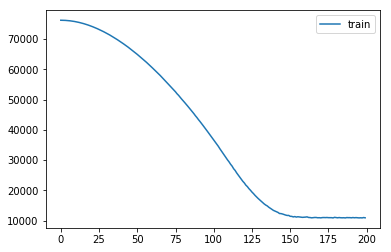

In [73]:
# examine what is the optimal number of epoch for the error to stablise
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [74]:
predict_y = model.predict(test_X)

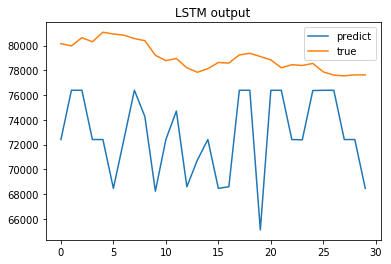

In [85]:
plt.plot(predict_y[0:30], label = 'predict')
plt.plot(test_y[0:30], label = 'true')
plt.title('LSTM output')
plt.legend()

# 5. Benchmarking with ARIMA output

In [44]:
log_data = np.log(data['CLOSE'])
train, test = log_data[0:7055], log_data[7026:-1]

In [48]:
train_model = auto_arima(train, error_action='ignore', suppress_warnings=True)#arima
train_model.fit(train)
predicted = train_model.predict(n_periods=30)

In [57]:
predict_list = []
order_list = []

for i in range (0, 30):
    print ('processing ', str(i))
    train_model = auto_arima(log_data[0:7055+i],error_action='ignore', suppress_warnings=True, seasonal = True, m = 12)#arima
    train_model.fit(log_data[0:7055+i])
    predicted = train_model.predict(n_periods=1)
    
    predict_list.append(predicted)
    order_list.append(train_model.order)

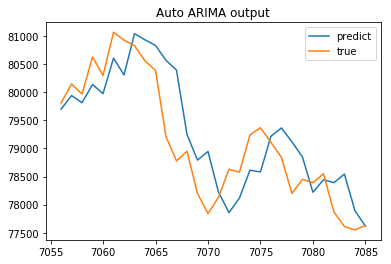

In [86]:
plt.plot(log_data.index[7056:7086], np.exp(predict_list), label = 'predict')
plt.plot(log_data.index[7056:7086], data['CLOSE'][7056:7086], label = 'true')
plt.title('Auto ARIMA output')
plt.legend()

# 6. Conclusion

As seen in the comparison, with the current features on hand and a basic LSTM model, the performance from auto arima is much better than LSTM model. We understand LSTM model might improve its performance with more features added and better tuned hyperparameters. However, consider the time and efforts needed and current highly volatile market, we would think Auto ARIMA is a better approach.